# Introduction

We approached this project by us each deciding on a factor that seemed important to us. We then each worked to gather that data and turn them into sub-metrics that we'd combine into one full metric.

To make it easier to combine these metrics into one, we normalized the metrics to all range between 0 and 1. This allowed us to simply combine the three metrics by taking an average of the three.

# The Metric

The three sub-metrics we each contributed were transportation accessibility, fire incidents, and playgrounds.

In [7]:
# Libraries we used
import geopandas as gpd
import pandas as pd
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Transportation accessibility

**Wilson Biggs**

To create a transportation accessibility score, my idea was to use the density of transit stops in each neighborhood. Being able to get places easily without a car is very important to me, so I felt that this was an important metric to look at when judging a neighborhood.

I used the [Port Authority of Allegheny County Transit Stops](https://data.wprdc.org/dataset/port-authority-of-allegheny-county-transit-stops) dataset to get the locations of every transit stop. However, each stop was not associated with a neighborhood; to be able to get the stops per neighborhood, I also used the [Neighborhoods](https://data.wprdc.org/dataset/neighborhoods2) dataset, which contained the borders of every neighborhood.

In [41]:
# Read data
neighborhoods = gpd.read_file('https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/pittsburghpaneighborhoods-.geojson')
stops = gpd.read_file('./Personal Notebooks/wbiggs-data/paac_stops_1909/PAAC_Stops_1909.dbf')

# Reproject data to matching CRS with meters as base (so I can calculate per-km)
# CRS used is based on the answer given here: https://gis.stackexchange.com/a/365569
neighborhoods = neighborhoods.to_crs('+proj=cea +lat_ts=40.440624 +lon_0=-79.995888 +units=m')
stops = stops.to_crs('+proj=cea +lat_ts=40.440624 +lon_0=-79.995888 +units=m')

I originally just used this data as-is, but I later realized that it made more sense to also include stops that were slightly outside of the neighborhood's borders -- especially as some borders straddled streets, and some stops would be on the wrong side of the street. To solve this, I decided to "buffer" the neighborhood's borders by 200 meters to include nearby stops.

In [42]:
hoods_buffer = neighborhoods.assign(
  old_geom = neighborhoods['geometry'],
  geometry = lambda df: df['geometry'].map(lambda geom: geom.buffer(200))
).assign(
  buffer_area = lambda df: df['geometry'].map(lambda geom: geom.area)
)

I then used geopandas to combine the two and calculate the number of transit stops per square kilometer.

In [43]:
# Count stops per neighborhood using a spatial join and groupby
stops_hoods_join = stops.sjoin(hoods_buffer)
hoods_points = hoods_buffer.join(stops_hoods_join.groupby('index_right').size().rename('points'),how='left')
hoods_points['points'] = hoods_points['points'].fillna(0)

# Calculate density
hoods_points['count_per_sq_km'] = hoods_points['points'] / (hoods_points['buffer_area'] / 1000000)

# Move the buffered geometry to buf_geom and move old_geom to geometry, so plots use the correct geometry
hoods_points['buf_geom'] = hoods_points['geometry']
hoods_points['geometry'] = hoods_points['old_geom']

Finally, I noticed that the scores were skewed pretty heavily, and I wanted those scores to be relatively even, where 50 would represent an "average" neighborhood. To achieve this, I fit a log-normal distribution to the scores and transformed it to a uniform distribution.

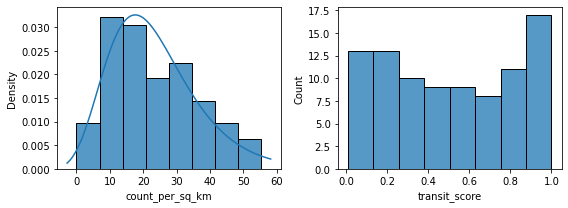

In [44]:
s, loc, scale = stats.lognorm.fit(hoods_points['count_per_sq_km'])

fig, ax = plt.subplots(1,2,figsize=(8, 3))

orig_plot = sns.histplot(hoods_points['count_per_sq_km'], stat='density', ax=ax[0])
space = np.linspace(*orig_plot.get_xlim(),100)
orig_plot.plot(space, stats.lognorm.pdf(space, s, loc, scale))

transformed = stats.lognorm.cdf(hoods_points['count_per_sq_km'], s, loc, scale)
hoods_points['transit_score'] = transformed / transformed.max() # Make it 0-1

sns.histplot(hoods_points['transit_score'], ax=ax[1])

fig.tight_layout()

Here are the best of the final scores I calculated, and those scores plotted on a map:

In [51]:
hoods_points = hoods_points.sort_values('transit_score', ascending = False)
hoods_points[['hood', 'transit_score']].head(10)

,hood,transit_score
29,Friendship,1.000000
39,Crawford-Roberts,0.990562
38,West Oakland,0.989049
35,East Liberty,0.982336
45,Terrace Village,0.970582
6,Central Northside,0.949724
70,Knoxville,0.948370
24,Bloomfield,0.945115
60,Beltzhoover,0.943842
31,Shadyside,0.938994


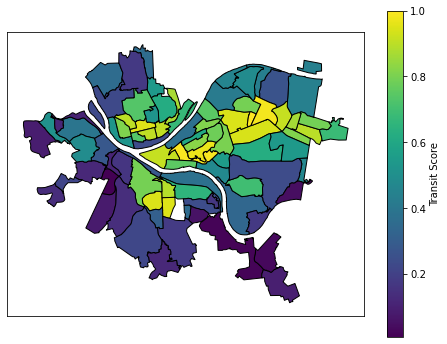

In [49]:
hoods_points.plot(
  column='transit_score',
  edgecolor='black',
  legend=True,
  legend_kwds={'label': 'Transit Score'},
  figsize=(8, 6)).tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

## Fire incidents

**Aidan Lillis**

I hear emergency vehicles drive by every night, so I decided to use a data set from the City of Pittsburgh showing Fire Incidents in the city of Pittsburgh. The less fire calls they have, the less noise and therefore a better neighborhood.

In [52]:
FireIncidents = pd.read_csv("https://data.wprdc.org/datastore/dump/8d76ac6b-5ae8-4428-82a4-043130d17b02")

Let's look at our data.

In [53]:
FireIncidents.head()

,call_no,incident_type,type_description,address,alarm_time,alarms,primary_unit,census_tract,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,F160029985,111.0,Building fire,"800 BLOCK CENTER ST, WILKINSBURG PA 15221",2016-04-21T05:01:04,1,231EN16,NaN,NaN,NaN,NaN,4.200356e+10,NaN,NaN,NaN,3-16,40.441275,-79.882485
1,F180022058,111.0,Building fire,"1100 BLOCK JANE ST, WILKINSBURG PA 15221",2018-03-13T08:34:43,1,231EN16,NaN,NaN,NaN,NaN,4.200356e+10,NaN,NaN,NaN,3-21,40.436342,-79.881003
2,F180022102,131.0,Passenger vehicle fire,"SB STATE HWY 28 SB AT 31S, PITTSBURGH PA 15212",2018-03-13T11:54:23,0,231EN32,2406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-1A,NaN,NaN
3,F170043431,131.0,Passenger vehicle fire,"1700 BLOCK BELLEAU DR, PITTSBURGH PA 15212",2017-05-31T08:39:47,0,231EN38,2509.0,Fineview,6.0,25.0,4.200325e+10,1.0,25.0,1.0,1-10,40.460303,-80.006980
4,F180021111,111.0,Building fire,"2400 BLOCK VILLAGE RD, PITTSBURGH PA 15205",2018-03-09T10:26:42,1,231EN31,2808.0,Fairywood,2.0,28.0,4.200356e+10,5.0,28.0,6.0,1-16,40.449009,-80.076607


That's a bit hard to read. Let's group it by neighborhood:

In [57]:
IncidentCount = FireIncidents.groupby('neighborhood')['call_no'].count().sort_values(ascending = True)

print(IncidentCount)

neighborhood
Mount Oliver Borough           6
Regent Square                  7
East Carnegie                 11
Mt. Oliver                    11
St. Clair                     11
                            ... 
Hazelwood                    217
South Side Flats             225
Central Business District    233
Squirrel Hill South          234
Carrick                      263
Name: call_no, Length: 91, dtype: int64


In [176]:
MinFires = IncidentCount.min()
MaxFires = IncidentCount.max()

NormalizedFires = 1 - (IncidentCount - MinFires) / (MaxFires - MinFires)

NormalizedFires.head()

neighborhood
Mount Oliver Borough    1.000000
Regent Square           0.996109
East Carnegie           0.980545
Mt. Oliver              0.980545
St. Clair               0.980545
Name: call_no, dtype: float64

## Playgrounds

**Jared Moynahan**

With the nicer weather coming around, I felt the urge to get more physical activity, and I recently discovered that playgrounds are an excellent and unique way to get exercise. A neighborhood with more playgrounds will be a healthier and therefore higher quality neighborhood.

In [60]:
pgData = pd.read_csv("https://data.wprdc.org/datastore/dump/e39ef76e-0a11-47c8-a86f-a37f55db7a2b") # read in the playgrounds data
pgData.head()

,id,name,equipment_type,manufacturer,safety_surface_type,ada_accessible,street_number,street,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,1780722587,Able Long Playground,Play Area 2 to 5,Little Tykes,Pour in Place,f,211.0,Coast Ave,Beechview,4,19,42003192000,5,19,6,4-28,40.408381,-80.028520
1,702514290,North Ave. Playground,Play Area 2 to 5,Playworld,SofSurfaces,f,377.0,W North Ave,Allegheny Center,1,22,42003562700,1,22,1,1-7,40.454526,-80.010188
2,1267038491,Vietnam Veteran's Playground,Slide,Little Tykes,SofSurfaces,f,108.0,Panther Hollow Rd,Squirrel Hill South,5,14,42003980500,3,14,4,2-8,40.434185,-79.944323
3,14898932,Schenley Overlook Playground,Swing 2 Bays,Little Tykes,SofSurfaces,t,NaN,Overlook Dr,Squirrel Hill South,5,14,42003980500,3,14,4,2-8,40.432130,-79.947774
4,204832406,Schenley Overlook Playground,Slide,Little Tykes,SofSurfaces,f,NaN,Overlook Dr,Squirrel Hill South,5,14,42003980500,3,14,4,2-8,40.432215,-79.947817


Not super useful just yet, let's use count() to see how many playgrounds are in each neighborhood:

In [65]:
pgCount = pgData.groupby('neighborhood').count()['id']
pgCount = pgCount.sort_values( ascending=False )
pgCount.head()

neighborhood
Squirrel Hill South    32
East Liberty           26
Beechview              21
Allegheny Center       15
South Side Slopes      14
Name: id, dtype: int64

Now we can merge this sorted data with a shapefile to show the concentration of playgrounds in Pittsburgh.

<AxesSubplot:>

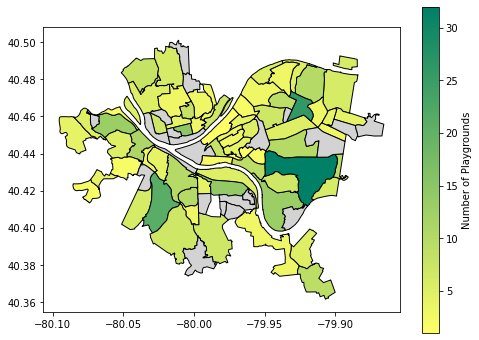

In [66]:
neighborhoods = gpd.read_file("https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/c5a93a8e-03d7-4eb3-91a8-c6b7db0fa261/download/pittsburghpaneighborhoods-.zip") # read in the shapefile
pg_map = neighborhoods.merge(pgCount, how='left', left_on='hood', right_on='neighborhood')
pg_map.plot(column='id', # set the data to be used for coloring
               cmap='summer_r',              # choose a color palette
               edgecolor="black",        # outline the districts in black
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Playgrounds"}, # label the legend
               figsize=(8, 6),         # set the size
               missing_kwds={"color": "lightgrey"} # set districts with no data to gray
               )

As you can see, the dark green Squirrel Hill South has the most playgrounds at 32, with East Liberty coming in 2nd with 26 playgrounds, and Beechview not far behind with 21 playgrounds.

In [98]:
pgMin = pgCount.min()
pgMax = pgCount.max()

pgScores = (pgCount) / (pgMax)
pgScores

neighborhood
Squirrel Hill South    1.00000
East Liberty           0.81250
Beechview              0.65625
Allegheny Center       0.46875
South Side Slopes      0.43750
                        ...   
Central Oakland        0.06250
Lower Lawrenceville    0.06250
Westwood               0.06250
Strip District         0.03125
West Oakland           0.03125
Name: id, Length: 68, dtype: float64

## Combining the data

To combine the data, the three scores were combined into a single dataframe, and then a column was added that averaged the three scores into one.

The playground and fire scores were problematic for averaging everything together (both were extremely heavily skewed), so the same transformations were applied to them that Wilson applied to the transit score (using exponential distribution instead, since they fit better, and the mode of both being 0 broke the log-normal distribution.) Then, the averaging was done.

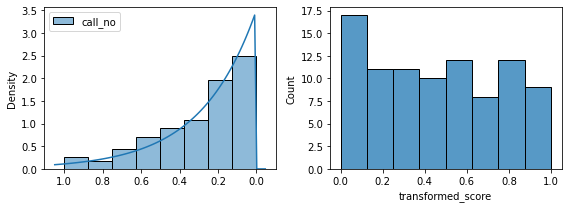

In [201]:
# Turn into dataframe, with 0s for any neighborhoods it's missing
fireFrame = pd.merge(hoods_points[['hood']], NormalizedFires.reset_index(), left_on='hood', right_on='neighborhood', how='left').fillna(0)

# un-reverse the fire scores temporarily
loc, scale = stats.expon.fit(1 - fireFrame[['call_no']])

fig, ax = plt.subplots(1,2,figsize=(8, 3))

orig_plot = sns.histplot(1 - fireFrame[['call_no']], stat='density', ax=ax[0])
space = np.linspace(*orig_plot.get_xlim(),100)
orig_plot.invert_xaxis()
orig_plot.plot(space, stats.expon.pdf(space, loc, scale))

transformed = stats.expon.cdf(1 - fireFrame[['call_no']], loc, scale)
fireFrame['transformed_score'] = 1- (transformed / transformed.max()) # Make it 0-1

sns.histplot(fireFrame['transformed_score'], ax=ax[1])

fig.tight_layout()

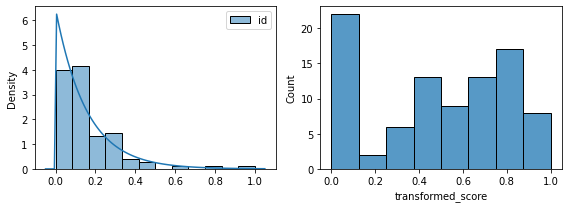

In [156]:
# Turn pgScores to dataframe, with 0s for the neighborhoods it's missing
pgFrame = pd.merge(hoods_points[['hood']], pgScores.reset_index(), left_on='hood', right_on='neighborhood', how='left').fillna(0)

loc, scale = stats.expon.fit(pgFrame[['id']])

fig, ax = plt.subplots(1,2,figsize=(8, 3))

orig_plot = sns.histplot(pgFrame[['id']], stat='density', ax=ax[0])
space = np.linspace(*orig_plot.get_xlim(),100)
orig_plot.plot(space, stats.expon.pdf(space, loc, scale))

transformed = stats.expon.cdf(pgFrame[['id']], loc, scale)
pgFrame['transformed_score'] = transformed / transformed.max() # Make it 0-1

sns.histplot(pgFrame['transformed_score'], ax=ax[1])

fig.tight_layout()

In [207]:
# Keep geometry for sake of plotting
combined = pd.merge(hoods_points[['hood', 'geometry', 'transit_score']], fireFrame[['hood', 'transformed_score']], left_on='hood', right_on='hood', how='left').rename(columns={'transformed_score': 'fire_score'})
combined = combined.merge(pgFrame[['neighborhood', 'transformed_score']], left_on='hood', right_on='neighborhood', how='left').rename(columns={'transformed_score': 'playground_score'})
combined = combined.fillna(0).drop('neighborhood', axis=1)

combined['final_score'] = combined[['transit_score', 'fire_score', 'playground_score']].mean(axis=1)

# The Best Neighborhood

So here's what we've all been waiting for!! Per our metric, the best neighborhood is...

In [208]:
combined.sort_values('final_score', ascending=False).head(5)

# SOME NEIGHBORHOODS ARE NOT LINING UP WITH MINE, E.G. SQUIRREL HILL SOUTH

,hood,geometry,transit_score,fire_score,playground_score,final_score
13,Allegheny Center,"POLYGON ((-450.761 5403252.929, -460.785 54032...",0.907007,0.500944,0.953337,0.787096
48,Regent Square,"POLYGON ((8382.576 5400731.669, 8422.642 54007...",0.468113,1.000000,0.839308,0.769140
17,Spring Garden,"POLYGON ((764.992 5405892.029, 840.614 5405675...",0.869257,0.811034,0.455580,0.711957
1,Crawford-Roberts,"POLYGON ((1141.614 5402825.275, 1144.477 54028...",0.990562,0.295826,0.802942,0.696443
3,East Liberty,"POLYGON ((6794.837 5404414.332, 6797.354 54043...",0.982336,0.057345,0.996337,0.678673


...Allegheny Center! With its high density of transit stops, low number of fire incidents, and high number of playgrounds, we think it's a great neighborhood.

Here are those results plotted on a map:

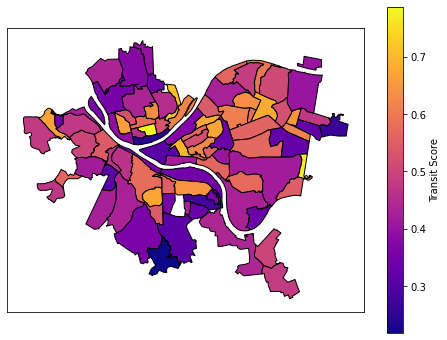

In [210]:
combined.plot(
  column='final_score',
  cmap='plasma',
  edgecolor='black',
  legend=True,
  legend_kwds={'label': 'Transit Score'},
  figsize=(8, 6)).tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)